In [1]:
### Simulation parameters
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10

seq_error = 0.01
don_var_lim=(0.8,1)
clone_var_lim=(0.1,0.4)
depth_lim = (4,10)
chars = ["A", "G", "C", "T"]

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline


### Generate cells 

In [3]:
all_cells = []
for don in range(n_donors):
    for cond in range(n_conditions):
        clone_ids = np.random.choice(n_clones_in_don, size=n_cells_per_donor_cond)
        clone_names = [f"d{don}_cl{cl_id}" for cl_id in clone_ids]
        cell_names = [f"Cell_{i}_donor{don}_condition{cond}_clone{clone_names[i]}" for i in range(len(clone_ids))]
        
        all_cells.append(pd.DataFrame({"donor": don, "condition": cond, 
                                       "clone": [f"{nm}" for nm in clone_names]}, index=cell_names))

all_cells_df = pd.concat(all_cells, axis=0, verify_integrity=True)
all_cells_df



,donor,condition,clone
Cell_0_donor0_condition0_cloned0_cl3,0,0,d0_cl3
Cell_1_donor0_condition0_cloned0_cl4,0,0,d0_cl4
Cell_2_donor0_condition0_cloned0_cl2,0,0,d0_cl2
Cell_3_donor0_condition0_cloned0_cl4,0,0,d0_cl4
Cell_4_donor0_condition0_cloned0_cl4,0,0,d0_cl4
...,...,...,...
Cell_295_donor1_condition2_cloned1_cl4,1,2,d1_cl4
Cell_296_donor1_condition2_cloned1_cl2,1,2,d1_cl2
Cell_297_donor1_condition2_cloned1_cl4,1,2,d1_cl4
Cell_298_donor1_condition2_cloned1_cl0,1,2,d1_cl0


In [4]:
# Make clones_meta_cond_df and clones_meta_df
clones_meta_cond_df = all_cells_df.groupby(["clone", "condition", "donor"]).size().to_frame('ncells').reset_index()
clones_meta_cond_df

,clone,condition,donor,ncells
0,d0_cl0,0,0,69
1,d0_cl0,1,0,58
2,d0_cl0,2,0,65
3,d0_cl1,0,0,46
4,d0_cl1,1,0,65
5,d0_cl1,2,0,63
6,d0_cl2,0,0,63
7,d0_cl2,1,0,44
8,d0_cl2,2,0,59
9,d0_cl3,0,0,74


In [5]:
clones_meta_df = clones_meta_cond_df.groupby(["clone", "donor"]).sum()["ncells"].to_frame("ncells").reset_index()
clones_meta_df

,clone,donor,ncells
0,d0_cl0,0,192
1,d0_cl1,0,174
2,d0_cl2,0,166
3,d0_cl3,0,187
4,d0_cl4,0,181
5,d1_cl0,1,183
6,d1_cl1,1,178
7,d1_cl2,1,181
8,d1_cl3,1,171
9,d1_cl4,1,187


## Plot the number of cells

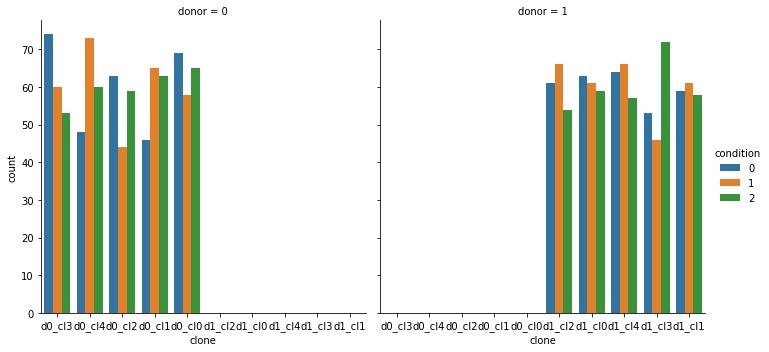

In [6]:
g = sns.catplot(data=all_cells_df.astype(str), x="clone", col="donor", hue="condition", kind="count")

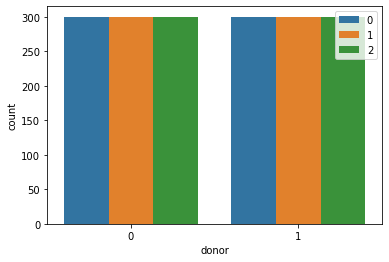

In [7]:
g = sns.countplot(data=all_cells_df.astype(str),x="donor", hue="condition")

plt.legend()

# Get the variant assignments for donor and clone

In [8]:
ref_char = np.random.choice(chars, n_positions)
ref = [f"{i}_{c}" for i, c in enumerate(ref_char)]

ref_df = pd.DataFrame(np.array([range(len(ref_char)),ref_char]).transpose(),index=ref, columns=["pos", "ref"])
ref_df.head()

,pos,ref
0_C,0,C
1_G,1,G
2_T,2,T
3_G,3,G
4_T,4,T


In [9]:
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10


## Donor variants

In [10]:
don_vars = []
for d in range(n_donors):
    curr_ref_vars = np.random.choice(ref_df.index.values, replace=False, size=n_donor_variants)
    # Pick variant not from reference
    curr_alt = [np.random.choice(list(set(chars)-set([ref_df.loc[x,"ref"]]))) for x in curr_ref_vars]
    curr_ref = [ref_df.loc[x,"ref"] for x in curr_ref_vars]
    curr_pos = [ref_df.loc[x,"pos"] for x in curr_ref_vars]
    
    # Setup donor variant df
    curr_v_df = pd.DataFrame(data=np.array([curr_alt,curr_ref_vars]).transpose(), 
                             index=curr_ref_vars, columns=["alt", "ref_id"])
    curr_v_df["ref"] = curr_ref
    curr_v_df["pos"] = curr_pos
    curr_v_df["donor"] = d
    curr_v_df.index = curr_v_df["ref_id"]+"_"+curr_v_df["donor"].astype(str)

    don_vars.append(curr_v_df)


don_vars_df = pd.concat(don_vars, verify_integrity=True)
don_vars_df

,alt,ref_id,ref,pos,donor
23_T_0,A,23_T,T,23,0
93_T_0,G,93_T,T,93,0
61_T_0,A,61_T,T,61,0
49_G_0,A,49_G,G,49,0
16_C_0,A,16_C,C,16,0
39_A_0,T,39_A,A,39,0
76_G_0,T,76_G,G,76,0
58_G_0,T,58_G,G,58,0
44_G_0,A,44_G,G,44,0
6_G_0,T,6_G,G,6,0


## Clone variants

In [11]:
clone_vars = []
for ind, val in clones_meta_df.iterrows():
    ## Generate clone-specific cars
    # a. number of variants using lamba
    num_vars = np.random.poisson(lam=1)+1
    
    # b. get positions, not from donor
    curr_don_ref = don_vars_df.loc[val["donor"]==don_vars_df["donor"], "ref_id"].values
    
    # c. Continue as with donor
    curr_ref_vars = np.random.choice(ref_df.index.drop(curr_don_ref), replace=False, size=num_vars)
    
    # Pick variant not from reference
    curr_alt = [np.random.choice(list(set(chars)-set([ref_df.loc[x,"ref"]]))) for x in curr_ref_vars]
    curr_ref = [ref_df.loc[x,"ref"] for x in curr_ref_vars]
    curr_pos = [ref_df.loc[x,"pos"] for x in curr_ref_vars]
    
    # Setup donor variant df
    curr_v_df = pd.DataFrame(data=np.array([curr_pos, curr_ref, curr_alt,curr_ref_vars]).transpose(), 
                             index=curr_ref_vars, columns=[ "pos", "ref", "alt", "ref_id"])
    curr_v_df["donor"] = val["donor"]
    curr_v_df["clone"] = val["clone"]
    curr_v_df.index = curr_v_df["ref_id"]+">"+curr_v_df["alt"]+"_"+curr_v_df["donor"].astype(str) + "_" +curr_v_df["clone"].astype(str)

    clone_vars.append(curr_v_df)


clone_vars_df = pd.concat(clone_vars, verify_integrity=True)
clone_vars_df

,pos,ref,alt,ref_id,donor,clone
67_T>C_0_d0_cl0,67,T,C,67_T,0,d0_cl0
55_G>C_0_d0_cl0,55,G,C,55_G,0,d0_cl0
92_A>C_0_d0_cl1,92,A,C,92_A,0,d0_cl1
68_A>G_0_d0_cl1,68,A,G,68_A,0,d0_cl1
42_A>C_0_d0_cl2,42,A,C,42_A,0,d0_cl2
40_C>G_0_d0_cl3,40,C,G,40_C,0,d0_cl3
86_T>A_0_d0_cl3,86,T,A,86_T,0,d0_cl3
1_G>C_0_d0_cl4,1,G,C,1_G,0,d0_cl4
34_T>C_0_d0_cl4,34,T,C,34_T,0,d0_cl4
96_A>C_1_d1_cl0,96,A,C,96_A,1,d1_cl0


In [12]:
print("Positions seen multiple times in a donor")
curr = clone_vars_df.groupby(["ref_id", "donor"]).size()
(curr[curr>1])

Positions seen multiple times in a donor


Series([], dtype: int64)

In [13]:
#clone_vars_df = pd.DataFrame(index=clone_meta_df.index, columns = [np.random.choice(n_positions)])

## For each cell generate pileup matrix for each nucleotide.
so cell1_A_df: [Pos_count, Neg_count, BQ]

parameters needed:  
- seq_error (0.001)  
- depth distribution log2(uniform(2,10))
- strand_assign: binomial(0.5)
- base quality average: constant of 30- all of them pass

In [14]:
from collections import Counter

In [15]:
counts = pd.DataFrame({"counts":np.floor(2**(np.random.randint(2,10, size=ref_df.shape[0]))),
                      "ref":ref_df["ref"], "pos":ref_df["pos"],
                      "ref_id":ref_df.index},
                      index=ref_df.index)
counts["counts"] = counts["counts"].astype(int)
counts

,counts,ref,pos,ref_id
0_C,32,C,0,0_C
1_G,512,G,1,1_G
2_T,4,T,2,2_T
3_G,64,G,3,3_G
4_T,64,T,4,4_T
...,...,...,...,...
95_A,32,A,95,95_A
96_A,512,A,96,96_A
97_A,32,A,97,97_A
98_C,4,C,98,98_C


In [16]:
counts.head()

,counts,ref,pos,ref_id
0_C,32,C,0,0_C
1_G,512,G,1,1_G
2_T,4,T,2,2_T
3_G,64,G,3,3_G
4_T,64,T,4,4_T


In [17]:
def nonspec_cell_vars(cell_ser, cell_nm, seq_err=0.001, chars=["A","C","G","T"]):
#    print(cell_ser)
    reads = cell_ser["counts"]
    ref = cell_ser["ref"]
    ref_id = cell_ser["ref_id"]
    seq_err_counts = np.random.binomial(reads,seq_err)
    oth_nts = list(set(chars)-set([ref]))
    out = {}
    if seq_err_counts>0:
        # Change the nt to the non alt allele
        out = Counter(np.random.choice(oth_nts, size=seq_err_counts,replace=True))
    else:
        out  = {x:0 for x in oth_nts}
    out[ref] = reads - seq_err_counts

    out["pos"] = cell_ser["pos"]
    out["cell"] = cell_nm
    
    return pd.Series(out)


def cell_nonspec_variants(curr_counts, cell_name):
    curr_cell_pile = curr_counts.apply(nonspec_cell_vars, args=(cell_name,), axis=1).reset_index().rename({"index":"ref_id"},axis=1)
    curr_cell_pile = curr_cell_pile.drop("ref_id",axis=1).melt(id_vars=["pos", "cell"], value_name="counts", var_name="nt")
    curr_cell_pile = (curr_cell_pile.loc[curr_cell_pile["counts"]!=0]).dropna()
    return curr_cell_pile

def donor_variant_pileup(d_v_ser,  cell_nm, don_var_lim, seq_err=0.001, chars=["A","C","G","T"]):
    #out = {}  
    reads = d_v_ser["counts"]
    ref = d_v_ser["ref"]
    alt = d_v_ser["alt"]
    pos = d_v_ser["pos"]
    ref_id = d_v_ser["ref_id"] 
    
    curr_af = np.random.uniform(don_var_lim[0],don_var_lim[1])
    curr_af_counts = int(np.floor(curr_af*counts.loc[ref_id, "counts" ]))
    seq_err_counts = np.random.binomial(reads,seq_err)
    oth_nts = list(set(chars)-set([alt]))
    if seq_err_counts>0:
        # Change the nt to the non alt allele
        out = Counter(np.random.choice(oth_nts, size=seq_err_counts,replace=True))
    else:
        out  = {x:0 for x in oth_nts}
    out[alt] = reads - seq_err_counts

    out["pos"] = d_v_ser["pos"]
    out["cell"] = cell_nm
    
    return pd.Series(out)

def cell_donor_variants(curr_cell_counts, cell_name, don_var_lim):
    curr_cell_pile = curr_cell_counts.apply(donor_variant_pileup, args=(cell_name,don_var_lim), axis=1).reset_index().rename({"index":"ref_id"},axis=1)
#     print('curr_cell_pile')
#     print(curr_cell_pile.head())
   # print(curr_cell_pile)
    curr_cell_pile = curr_cell_pile.drop("ref_id",axis=1).melt(id_vars=["pos", "cell"], value_name="counts", var_name="nt")
    curr_cell_pile = (curr_cell_pile.loc[curr_cell_pile["counts"]!=0]).dropna()
    return curr_cell_pile

def cell_clone_variants(curr_cell_counts, cell_name, clone_var_lim):
    curr_cell_pile = curr_cell_counts.apply(donor_variant_pileup, args=(cell_name,clone_var_lim), axis=1).reset_index().rename({"index":"ref_id"},axis=1)
    curr_cell_pile = curr_cell_pile.drop("ref_id",axis=1).melt(id_vars=["pos", "cell"], value_name="counts", var_name="nt")
    curr_cell_pile = (curr_cell_pile.loc[curr_cell_pile["counts"]!=0]).dropna()
    return curr_cell_pile

pileups_chars = {}


def cell_variants(cell_ser, ref_df, don_vars_df, clone_vars_df, seq_err=0.001, depth_lim=(2,10), strand_bin=0.5,
                 don_var_lim=(0.8,1), clone_var_lim=(0.1,0.5)):
    #cell_pileups = {}
    curr_clone = cell_ser["clone"]
    curr_don = cell_ser["donor"]
    cell_name = cell_ser.name
    curr_don_vars = don_vars_df.loc[don_vars_df["donor"]==curr_don].set_index("ref_id")
    curr_cl_vars = clone_vars_df.loc[clone_vars_df["clone"]==curr_clone].set_index("ref_id")
    
    # Generate counts at each position
    counts = pd.DataFrame({"counts":np.floor(2**(np.random.randint(2,10, size=ref_df.shape[0]))),
                      "ref":ref_df["ref"], "pos":ref_df["pos"],
                      "ref_id":ref_df.index, "cell": cell_name},
                      index=ref_df.index)
    counts["counts"] = counts["counts"].astype(int)
    

    # First construct donor variants
    cell_donSpec_counts = counts.loc[curr_don_vars.index]
    cell_donSpec_counts["alt"] = curr_don_vars["alt"]
    cell_donSpec_pileup = cell_donor_variants(cell_donSpec_counts, cell_name, don_var_lim)

    # Construct clone variants
    cell_cloneSpec_counts = counts.loc[curr_cl_vars.index]
    cell_cloneSpec_counts["alt"] = curr_cl_vars["alt"]
    cell_cloneSpec_pileup = cell_clone_variants(cell_cloneSpec_counts, cell_name, clone_var_lim)
    
#     for d_v in curr_don_vars:
#         curr_don_pileup = {}
#         curr_ref = curr_don_vars.loc[d_v, "ref"]
#         curr_alt = curr_don_vars.loc[d_v, "alt"]
#         curr_pos = curr_don_vars.loc[d_v, "pos"]
#         curr_ref_id = curr_don_vars.loc[d_v, "ref_id"] 
#         curr_af = np.random.uniform(clone_var_lim[0],clone_var_lim[1])
#         curr_af_counts = int(np.floor(curr_af*counts.loc[curr_ref_id, "counts" ]))
#         seq_err_counts = np.random.binomial(counts.loc[curr_ref_id, "counts"],seq_err)
#         curr_af_counts -= seq_err_counts
#         if len(seq_error_counts)>0:
#             # Change the nt to the non alt allele
#             seq_err_counts = Counter(np.random.choice(set(chars)-set([curr_alt]), size=seq_err_counts,replace=True))
            
        
    # Non-donor and non-clone vars
    non_spec_counts = counts.drop(curr_don_vars.index).drop(curr_cl_vars.index)
    non_spec_pileup = cell_nonspec_variants(non_spec_counts, cell_name)

#     print(cell_donSpec_counts.head())
#     print(cell_cloneSpec_counts.head())
#     print(non_spec.head())
    # concat donor-, clone-, and non-specific pileup dfs
    out_df = pd.concat([cell_donSpec_pileup, cell_cloneSpec_pileup, non_spec_pileup], axis=0)
    out_df["donor"] = cell_ser["donor"]
    out_df["condition"] = cell_ser["condition"]
    return out_df



pileups_all.head()


pileups_all = all_cells_df.apply(cell_variants, 
                               args=(ref_df, don_vars_df, clone_vars_df, seq_error, depth_lim, 0.5, 
                                     don_var_lim, clone_var_lim), axis=1)

pileups_df = pd.concat(pileups_all.values)

NameError: name 'pileups_all' is not defined

In [ ]:
pileups_df

## Save pileups

In [ ]:
# ## Convert to nt's

# for nt, curr_out in pileups_df.groupby(["nt"]):
#     curr_out.to_csv(join(outdir, f"{nt}.counts.txt"))